## P64 
# Recurrent neural networks for news group documents classiﬁcation.

***
### Authors: Julen Azpiroz and Asier Barrasa.


## Objectives
The aim of this project is to clasiffy a set of news among 20 diferent classess.

In [1]:
# Imports
import os
import sys
from pprint import pprint

from sklearn.model_selection import train_test_split
import numpy as np
from random import sample 

# import contractions
import contractions

#Keras imports
import keras
from keras.preprocessing import sequence, text
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Flatten, Embedding, LSTM, CuDNNLSTM, Activation
from keras.layers.recurrent import LSTM
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.models import load_model
from keras import backend as K

import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Define functions

In [2]:
def printAverage(lst):
    lengths = [len(i.split()) for i in lst]
    lengths = np.sum(lengths)/len(texts)
    return int(np.round(lengths))

# Print confision matrix
# For normalization set normalize =  True
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Process the data set
[Link](http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz) to dataset, rename the unzipped folder or change de name bellow.

In [3]:
NEWS_DIR = "20_newsgroup"

texts = []
labels = []
labels_index = {}

for name in sorted(os.listdir(NEWS_DIR)):
    current_path = os.path.join(NEWS_DIR,name)
    # Check if the dir is a dir
    if os.path.isdir(current_path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fnames in sorted(os.listdir(current_path)):
            # Check if the file is a number
            if fnames.isdigit():
                # Get the path to each docuemnt on the current dir
                file_path = os.path.join(current_path,fnames)
                with open(file_path, encoding='latin-1') as f:
                    t = f.read()
                    # Skip the header finding the second appearance of \n\n
                    i = t.find('\n\n')
                    i2 = t.find('\n\n', i+1)
                    if i2 > 0:
                        t = t[i2:]
                        t = contractions.fix(t)
                    texts.append(t)
                labels.append(label_id)

In [4]:
labels_index.keys()

label_names = []
for i in labels_index.keys():
    label_names.append(i)
    
print(label_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### Print some stats about the data

In [5]:
print ("There are {:,} texts".format(len(texts)))
print("There are {} classes".format(len(labels_index)))
print("The average of words on each text: {}".format(printAverage(texts)))
print("Number of appearances of each class")
labels_count = dict((x,labels.count(x)) for x in set(labels))
pprint(labels_count)

There are 18,828 texts
There are 20 classes
The average of words on each text: 221
Number of appearances of each class
{0: 799,
 1: 973,
 2: 985,
 3: 982,
 4: 961,
 5: 980,
 6: 972,
 7: 990,
 8: 994,
 9: 994,
 10: 999,
 11: 991,
 12: 981,
 13: 990,
 14: 987,
 15: 997,
 16: 910,
 17: 940,
 18: 775,
 19: 628}


# Index GloVe vectors

Uncomment the code bellow for use

[Link](http://nlp.stanford.edu/data/glove.6B.zip) to GloVe, after unzipping extract the file **_glove.6B.100d.txt_** in the root folder of the project.

In [6]:
# model_idx = {}

# with open("glove.6B.100d.txt",encoding="utf8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         nums = np.asarray(values[1:], dtype='float32')
#         model_idx[word] = nums

# vector_size = 100

# Index Fasttext vectors

[Link](https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki-news-300d-1M.vec.zip) to Fasttext download.

In [7]:
model_idx = {}

with open("wiki-news-300d-1M.vec",encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        nums = np.asarray(values[1:], dtype='float32')
        model_idx[word] = nums
        
vector_size = 300

### Print some stats about pre-trained models

In [8]:
print("There are {:,} word vectors".format(len(model_idx)))    
print('\n')
print('Example of vector for word: hello \n')
print(model_idx['hello'])

There are 999,995 word vectors


Example of vector for word: hello 

[-1.920e-01  1.544e-01  4.670e-02  5.920e-02  1.369e-01 -7.720e-02
 -3.840e-02  5.370e-02  1.435e-01 -1.353e-01 -5.300e-02 -6.680e-02
  1.850e-02  8.730e-02  9.030e-02  1.663e-01  3.500e-03 -2.102e-01
  2.010e-01 -2.490e-02 -2.790e-02 -3.241e-01 -6.600e-03 -2.640e-02
 -1.628e-01 -1.094e-01 -8.820e-02  9.700e-03  1.228e-01  5.900e-03
 -5.100e-02  6.490e-02  1.577e-01  1.740e-02  9.910e-02  1.328e-01
 -5.860e-02  1.814e-01 -9.800e-03  1.877e-01  5.180e-02 -6.970e-02
 -6.290e-02 -1.981e-01 -1.373e-01 -8.110e-02 -6.310e-02 -6.390e-02
  1.244e-01 -2.470e-02  2.250e-02 -3.174e-01 -8.462e-01 -1.248e-01
  8.240e-02  2.120e-02  9.960e-02 -3.440e-02  1.383e-01 -9.830e-02
  1.637e-01 -1.906e-01 -1.969e-01  1.473e-01  1.318e-01 -7.000e-02
  3.040e-02 -3.450e-02  1.507e-01 -1.786e-01  1.038e-01 -3.500e-03
 -9.300e-02  1.255e-01  1.431e-01  1.050e-01 -3.320e-02  1.255e-01
  3.390e-02  2.101e-01 -2.050e-01 -1.511e-01 -2.529e-01 -8.8

# Vectorize text

- Set all the text to lowercase
- Apply a filter, remove basic puntuation, tabs and newlines


In [9]:
MAX_NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 1000

tokenizer = text.Tokenizer(num_words = MAX_NUM_WORDS,  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=" ")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Finded {:,} unique words'.format(len(word_index)))

Finded 153,799 unique words


### Format the data to the NN

Fix the length of each sequence

In [10]:
data = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels))

## Generate the embebeding matrix

In [11]:
num_words = min(MAX_NUM_WORDS, len(word_index)+1) 

embedding_matrix = np.zeros((num_words, vector_size))
not_founded = []
for word, i in word_index.items():
    if i >= num_words:
        continue
    vector = model_idx.get(word)
    if vector is not None:
        embedding_matrix[i] = vector
    else:
        not_founded.append(word)

In [12]:
print("Print some examples from not founded words from a total of {:,} not founded words.\n".format(len(not_founded)))
print(len(not_founded))

Print some examples from not founded words from a total of 2,669 not founded words.

2669


## Split the data on trainning and test groups

In [13]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=4000, shuffle=True, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000,shuffle=False)

print('Trainning size --> {:,}'.format(x_train.shape[0]))
print('Validation size -> {:,}'.format(x_val.shape[0]))
print('Test size -------> {:,}'.format(x_test.shape[0]))

print('Trainning labels size -> {}'.format(y_train[0]))

Trainning size --> 13,828
Validation size -> 1,000
Test size -------> 4,000
Trainning labels size -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# LSTM

## Make embedding layer

Associate the sequeneces imputs with the corresponding values on embedding matrix

In [14]:
embedding_layer = Embedding(num_words,
                            vector_size,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## Make the Neural Network



In [15]:
# Uncomment for loading previously trained model
# model = load_model('my_model.h5')

In [16]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [17]:
model = Sequential()
model.add(embedding_layer)

# Add LSTM layer with dropout with a 10% chance of removing any element
model.add(CuDNNLSTM(128))
model.add(Dense(256, activation='relu'))
model.add(Dense(20, activation='softmax'))
# Print the model
print(model.summary())
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])


history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=30,
                    validation_data=(x_val, y_val),callbacks=[tbCallBack])

scores = model.evaluate(x_test, y_test)

print("Test set %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
model.save('my_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 300)         6000000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               220160    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                5140      
Total params: 6,258,324
Trainable params: 258,324
Non-trainable params: 6,000,000
_________________________________________________________________
None
Train on 13828 samples, validate on 1000 samples
Epoch 1/30
13828/13828 [==============================] - 20s 1ms/step - loss: 2.8762 - acc: 0.1159 - val_loss: 2.7247 - val_acc: 0.1340
Epoch 2/30
13828/13828 [==============================] - 19s 1ms/s

# Print confusion matrix

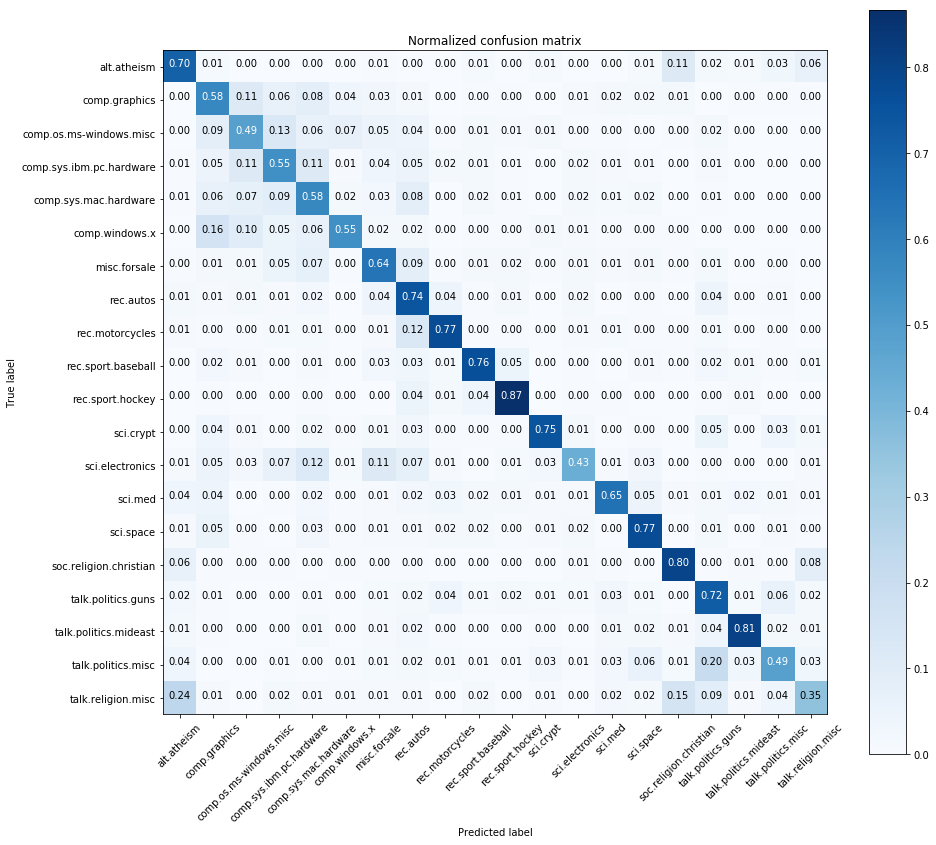

In [18]:
y_pred = model.predict(x_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# # Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
fig.align_labels()

fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-" + str(30) + ".png", pad_inches=5.0)